In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from qiskit import QuantumCircuit
from scipy.linalg import expm, eig
from scipy.special import comb 


N = 2
S = float(N)/2
Omega = np.pi*0.5
g = np.pi*0.5
mJ = np.arange(-S, S+1, dtype=float)
Jz2 = np.diag(np.square(mJ)).astype(complex)
Jz = np.diag(mJ).astype(complex)
Jp = np.diag(np.sqrt(S*(S+1) - mJ[:-1]*mJ[1:]), -1).astype(complex)
Jm = np.diag(np.sqrt(S*(S+1) - mJ[1:]*mJ[:-1]), 1).astype(complex)
Rx = expm(-1j*Omega*(Jp + Jm)/2)
Ry = expm(-Omega*(Jp - Jm)/2)
Sq = expm(-1j*g*Jz2)
psi0 = np.zeros(N+1, dtype=complex)
psi0[0] = 1

n_theta = 5
n_phi = 4

CSS = [[np.zeros(N+1, dtype=complex)]*n_phi for i in range(n_theta)]
for i in range(n_theta):
    for j in range(n_phi):
        theta = i * np.pi / (n_theta - 1)
        phi = j * 2*np.pi / n_phi - np.pi
        css = np.zeros(N+1, dtype=complex)
        for k in range(N+1):
            css[k] = np.sqrt(comb(N, k)) * np.cos(theta/2)**(N-k) * np.sin(theta/2)**k
            css[k] *= np.exp(-1j*k*phi);
        CSS[i][j] = css

class Env(object):
    
    def __init__(self, Omega, var=0.00):
        super(Env, self).__init__()
        self.Omega = Omega
        self.n_actions = 3
        self.actions = [Rx, Ry, Sq]
        self.n_states = n_theta * n_phi
        self.psi = psi0
        self.state = self.husimiQ()
        self.n_steps = 10
        self.t = 0
        self.threshold = 0.95
        
    def reset(self):
        self.psi = psi0
        self.state = self.husimiQ()
        self.t = 0

        return self.state

    def step(self, action):
        U = self.actions[action]
        self.psi = U.dot(self.psi)
        QFI = np.einsum('i,ij,j->', np.conjugate(self.psi), Jz2, self.psi) - np.abs(np.einsum('i,ij,j->', np.conjugate(self.psi), Jz, self.psi))**2
        QFI = np.real(QFI)
        QFI *= 4
        QFI /= N**2
        
        done =( QFI > self.threshold or self.t >= self.n_steps-1)
        rwd = done * QFI
        if QFI > self.threshold:
            self.t += 1
            self.state = self.husimiQ()
        
        return self.state, rwd, done, QFI
        
    def husimiQ(self):
        Q = np.zeros([n_theta, n_phi])
        for i in range(n_theta):
            for j in range(n_phi):
                Q[i][j] = abs(np.conjugate(CSS[i][j]).dot(self.psi)) ** 2
        return Q.reshape(n_theta * n_phi)

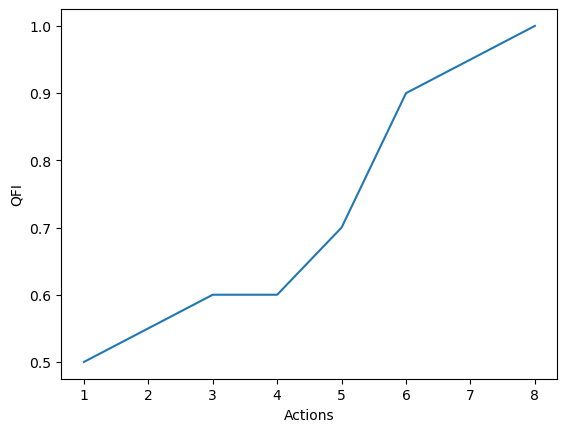

        ┌───┐   ┌─────────┐                                      
q_0: ───┤ S ├───┤ Rx(π/2) ├──────────────────────────────────────
     ┌──┴───┴──┐├─────────┤┌─────────┐┌───┐┌─────────┐┌─────────┐
q_1: ┤ Rx(π/2) ├┤ Ry(π/2) ├┤ Ry(π/2) ├┤ S ├┤ Ry(π/2) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└─────────┘└───┘└─────────┘└─────────┘


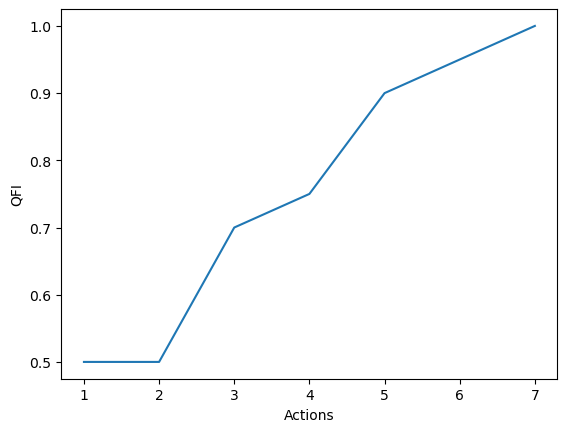

     ┌─────────┐┌─────────┐   ┌───┐              
q_0: ┤ Rx(π/2) ├┤ Rx(π/2) ├───┤ S ├──────────────
     ├─────────┤└──┬───┬──┘┌──┴───┴──┐┌─────────┐
q_1: ┤ Ry(π/2) ├───┤ S ├───┤ Rx(π/2) ├┤ Ry(π/2) ├
     └─────────┘   └───┘   └─────────┘└─────────┘


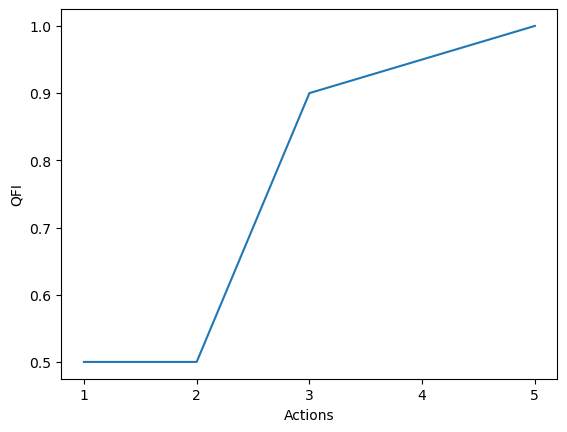

     ┌─────────┐┌─────────┐           
q_0: ┤ Rx(π/2) ├┤ Rx(π/2) ├───────────
     └──┬───┬──┘├─────────┤┌─────────┐
q_1: ───┤ S ├───┤ Ry(π/2) ├┤ Ry(π/2) ├
        └───┘   └─────────┘└─────────┘


In [2]:
# Define the quantum agent
class QuantumAgent(object):
    def __init__(self, env, learning_rate):
        super(QuantumAgent, self).__init__()
        self.env = env
        self.n_actions = env.n_actions
        self.current_state = None
        self.episode_actions = []  # Actions taken in the current episode
        self.policy = np.ones(self.n_actions) / self.n_actions  # Initialize the policy uniformly
        self.learning_rate = learning_rate  # Set the learning rate
        
    def select_action(self):
        # Sample an action from the current policy
        return np.random.choice(self.n_actions, p=self.policy)
    
    def update_policy(self, action_index, qfi):
        qfi_normalized = abs((qfi - self.env.threshold) / (1 - self.env.threshold))
        update = self.learning_rate * qfi_normalized * (np.eye(self.n_actions)[action_index] - self.policy[action_index])
        self.policy = self.policy + update
        
        # Ensure that the policy probabilities remain non-negative
        self.policy = np.maximum(self.policy, 0)
        
        # Normalize the policy distribution
        self.policy = self.policy / np.sum(self.policy)
    
    
    def train(self, num_episodes):
            for episode in range(num_episodes):
                self.current_state = self.env.reset()
                self.episode_actions = []  # Reset the actions for each episode
                done = False
                episode_qfi = []  # QFI values for actions in the episode

                while not done:
                    action = self.select_action()
                    next_state, reward, done, qfi = self.env.step(action)

                    # Store the actions taken in the current episode
                    self.episode_actions.append(action)

                    # Store the QFI value after each action

                    episode_qfi.append(qfi)

                    self.current_state = next_state

                # Draw the quantum circuit for the episode
                qc = self.generate_quantum_circuit(self.episode_actions)

                # Update the policy based on the action taken and QFI
                for i, action in enumerate(self.episode_actions):
                    self.update_policy(action, episode_qfi[i])

                # Plot the QFI for each episode
                plt.figure()
                plt.plot(episode_qfi)
                plt.xlabel('Action')
                plt.ylabel('QFI')
                plt.title(f'QFI - Episode {episode}')
                plt.show()

                print(qc)
            
    def generate_quantum_circuit(self, episode_actions):
        # Generate a quantum circuit based on the actions taken in the episode
        qc = QuantumCircuit(2)
        for action in episode_actions:
            r= random.randint(0, 1)
            if action == 0:
                qc.rx(self.env.Omega, [r])  # Apply Rx gate to both qubits
            elif action == 1:
                qc.ry(self.env.Omega, [r])  # Apply Ry gate to both qubits
            elif action == 2:
                qc.s(r)  # Apply S gate only to the first qubit
            elif action == 3:
                qc.h(r)  # Apply H gate to the first qubit
            elif action == 4:
                qc.cx(0, 1)  # Apply CNOT gate with control qubit 0 and target qubit 1

        return qc



# Create an instance of the environment
env = Env(Omega=np.pi * 0.5)

# Set the learning rate for the agent
learning_rate = 0.1

# Create an instance of the quantum agent
agent = QuantumAgent(env, learning_rate)

# Train the agent
agent.train(num_episodes=3)